### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sympy import re

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "adult":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split
        import re
  
        # fetch dataset 
        adult = fetch_ucirepo(id=2) 
        
        # data (as pandas dataframes) 
        X_df = adult.data.features 
        y_df = adult.data.targets 

        target_column = y_df.iloc[:, 0]

        target_values_cleaned = target_column.astype(str).str.strip().apply(lambda x: re.sub(r'[^\w\s<>=]', '', x)).str.strip() # Remove all non-word, non-whitespace, non-comparison characters # Strip again after removing hidde

        # . Encode the target variable
        y = LabelEncoder().fit_transform(target_values_cleaned.to_numpy().ravel())

        print(y[0:9])
   

        # list all the features
        print(X_df.columns.tolist())
        

        numeric_features = ['capital-gain', 'capital-loss', 'age', 'fnlwgt', 'education-num', 'hours-per-week']
        categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


        # Create preprocessing pipelines
        numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

          #  Build the master preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])
        
        # 7. Apply the transformations
        X = preprocessor.fit_transform(X_df)

        print(f"Shape of X after preprocessing: {X.shape}")
        
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=0.7,  # 70% for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test

        print(f"X_train type: {type(X_train)}, ndim: {X_train.ndim}, shape: {X_train.shape}")
        print(f"y_train type: {type(y_train)}, ndim: {y_train.ndim}, shape: {y_train.shape}")
        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")


    return train_data, test_data, val_data


In [5]:
train_data, test_data, val_data = generate_data("adult")

[0 0 0 0 0 0 0 1 1]
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Shape of X after preprocessing: (48842, 108)
Training data shape: (34189, 108), (34189,)
Test data shape: (14653, 108), (14653,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 108)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 1)
Shape of training data: (34189, 109)
Shape of test data: (14653, 109)

Data successfully processed and concatenated.
Shape of final training data: (34189, 109)


In [6]:
# print 1st 10 rows of training data
print(train_data[:10,-1])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Calculate Statistics function

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [8]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Adult: NN

In [9]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("adult")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





[0 0 0 0 0 0 0 1 1]
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Shape of X after preprocessing: (48842, 108)
Training data shape: (34189, 108), (34189,)
Test data shape: (14653, 108), (14653,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 108)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 1)
Shape of training data: (34189, 109)
Shape of test data: (14653, 109)

Data successfully processed and concatenated.
Shape of final training data: (34189, 109)


### Neural Network

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

In [45]:
class MLP(nn.Module):
    def __init__(self, input_features=14, hidden_units=64, num_classes=1):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            #nn.Linear(in_features=hidden_units, out_features=32),
            #nn.ReLU(),
            nn.Linear(hidden_units, num_classes),
        )

    def forward(self, x):
        return self.network(x)
    
# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = MLP(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification
        self.strict_loading = False 

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [46]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = train_data.shape[1] - 1

### Regular training

In [49]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=input_dim, hidden_units=2, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='MLP-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 221    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
----------------------------------------------------

--- Starting Training for 1 epochs on train_loader ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v5.ckpt


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v5.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v5.ckpt ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8386
AUC: 0.8938
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35926729440689087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on Test Set ---

--- Confusion Matrix ---
[[10456   691]
 [ 1673  1833]]

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.86      0.94      0.90     11147
     Class 1       0.73      0.52      0.61      3506

    accuracy                           0.84     14653
   macro avg       0.79      0.73      0.75     14653
weighted avg       0.83     

## Weighted ROC curve

In [35]:
NUM_CLASSIFIERS = 50
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [36]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    # 1. Instantiate the LightningModule
    model = LitClassifier(input_features=input_dim, hidden_units=64, learning_rate=LEARNING_RATE)
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     

--- Starting Fold 1/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7506
AUC: 0.8019
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5191550254821777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7694
AUC: 0.9055
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.85259610414505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7784
AUC: 0.9069
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6847773790359497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7807
AUC: 0.9086
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6372854113578796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.7907
AUC: 0.9092
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5561321973800659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.7946
AUC: 0.9089
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.527717649936676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.7960
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4978428781032562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.7995
AUC: 0.9095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4891781210899353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8047
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.44948941469192505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8077
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.43593859672546387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8105
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4201076924800873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8170
AUC: 0.9096
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40321600437164307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8334
AUC: 0.9098
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36717110872268677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8317
AUC: 0.9097
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36520281434059143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8244
AUC: 0.9099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3799261748790741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8372
AUC: 0.9099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3569084703922272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8390
AUC: 0.9100
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3463960886001587
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8412
AUC: 0.9099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34533262252807617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8427
AUC: 0.9095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3376231789588928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8450
AUC: 0.9094
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33100172877311707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8478
AUC: 0.9097
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3260774612426758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8513
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32265615463256836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8492
AUC: 0.9092
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.323397696018219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8490
AUC: 0.9097
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3236035108566284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8515
AUC: 0.9099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31846585869789124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8504
AUC: 0.9096
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3198479115962982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8515
AUC: 0.9090
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.32000732421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8471
AUC: 0.9093
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3213629126548767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8470
AUC: 0.9098
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32206442952156067
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8460
AUC: 0.9098
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32347118854522705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8424
AUC: 0.9091
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3298869729042053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8411
AUC: 0.9095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33356380462646484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8384
AUC: 0.9092
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.338316947221756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8372
AUC: 0.9084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3368205726146698
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8377
AUC: 0.9089
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34106796979904175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8260
AUC: 0.9083
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3600282073020935
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8174
AUC: 0.9091
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37618502974510193
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8156
AUC: 0.9084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37645992636680603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8057
AUC: 0.9079
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3951076567173004
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7799
AUC: 0.9081
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4497542977333069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7927
AUC: 0.9079
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4237014949321747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7767
AUC: 0.9082
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46703800559043884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7642
AUC: 0.9080
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4958440065383911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7608
AUC: 0.9077
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.505932092666626
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7433
AUC: 0.9073
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5539416670799255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7060
AUC: 0.9064
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6344317197799683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7130
AUC: 0.9058
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6432850956916809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6896
AUC: 0.9061
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7102712988853455
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6094
AUC: 0.9056
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.023722767829895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v1.ckpt


--- Fold 1 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4102
AUC: 0.8967
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.5420475006103516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

--- Starting Fold 2/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7661
AUC: 0.8062
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.434705138206482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7817
AUC: 0.9019
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.82110196352005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7890
AUC: 0.9039
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6934641599655151
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7945
AUC: 0.9055
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6060010194778442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.8015
AUC: 0.9071
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.537466287612915
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.8017
AUC: 0.9077
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5098870396614075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8122
AUC: 0.9084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4545150101184845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8139
AUC: 0.9084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.439489483833313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8164
AUC: 0.9085
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.423385888338089
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8212
AUC: 0.9087
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40739092230796814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8270
AUC: 0.9084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3751092851161957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8278
AUC: 0.9083
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3783835470676422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8312
AUC: 0.9087
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3638121485710144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8323
AUC: 0.9086
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36515501141548157
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8461
AUC: 0.9081
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33217504620552063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8387
AUC: 0.9078
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34692931175231934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8447
AUC: 0.9078
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33066603541374207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8424
AUC: 0.9076
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3349967300891876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8484
AUC: 0.9076
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3303564190864563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8443
AUC: 0.9068
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33274462819099426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8537
AUC: 0.9071
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3198308050632477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8515
AUC: 0.9074
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32062003016471863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8557
AUC: 0.9075
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3160913586616516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8540
AUC: 0.9071
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3176118731498718
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8557
AUC: 0.9066
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3156404495239258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8571
AUC: 0.9070
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31607183814048767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8548
AUC: 0.9070
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.318805456161499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8541
AUC: 0.9066
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.318141907453537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8509
AUC: 0.9067
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32458895444869995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8507
AUC: 0.9060
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3231906294822693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8525
AUC: 0.9064
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32283464074134827
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8375
AUC: 0.9056
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34217801690101624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8463
AUC: 0.9061
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3339727520942688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8385
AUC: 0.9058
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34156525135040283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8385
AUC: 0.9057
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34508422017097473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8298
AUC: 0.9057
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3594881296157837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8199
AUC: 0.9051
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37421223521232605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8259
AUC: 0.9055
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.362570196390152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8081
AUC: 0.9050
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3994639813899994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8068
AUC: 0.9052
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4008132219314575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8032
AUC: 0.9054
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.41542717814445496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7755
AUC: 0.9048
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.45773571729660034
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7506
AUC: 0.9051
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5097470879554749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7513
AUC: 0.9046
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5137840509414673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7281
AUC: 0.9047
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5770602822303772
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7205
AUC: 0.9046
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6070741415023804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7152
AUC: 0.9043
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6241894364356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6736
AUC: 0.9040
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7480714917182922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6036
AUC: 0.9026
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0461702346801758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v1.ckpt


--- Fold 2 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3897
AUC: 0.8943
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.595834493637085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

--- Starting Fold 3/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7680
AUC: 0.7859
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3945378065109253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7843
AUC: 0.9053
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8007264733314514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7913
AUC: 0.9085
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.647725522518158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7962
AUC: 0.9097
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5892341732978821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.8009
AUC: 0.9113
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5359625816345215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8059
AUC: 0.9120
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4923710525035858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8127
AUC: 0.9125
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4515232741832733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8217
AUC: 0.9127
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40715929865837097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8246
AUC: 0.9123
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40078485012054443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8247
AUC: 0.9124
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.38573434948921204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8337
AUC: 0.9128
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36175408959388733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8321
AUC: 0.9128
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35589390993118286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8308
AUC: 0.9124
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36646267771720886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8408
AUC: 0.9131
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35111913084983826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8443
AUC: 0.9127
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33476462960243225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8437
AUC: 0.9127
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32693684101104736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8514
AUC: 0.9128
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3195143938064575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8502
AUC: 0.9122
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3150582015514374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8535
AUC: 0.9121
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3126789629459381
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8539
AUC: 0.9118
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3101918697357178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8532
AUC: 0.9118
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31072744727134705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8523
AUC: 0.9120
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3133126497268677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8557
AUC: 0.9117
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30606338381767273
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8542
AUC: 0.9110
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30773428082466125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8556
AUC: 0.9114
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3068091869354248
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8554
AUC: 0.9112
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3082132041454315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8561
AUC: 0.9114
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30738842487335205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8546
AUC: 0.9115
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3130700886249542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8529
AUC: 0.9110
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3118690550327301
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8460
AUC: 0.9108
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32563263177871704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8486
AUC: 0.9105
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.317648708820343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8445
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32522398233413696
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8457
AUC: 0.9106
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32648393511772156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8419
AUC: 0.9105
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33262452483177185
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8380
AUC: 0.9101
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.337699830532074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8296
AUC: 0.9104
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35173889994621277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8167
AUC: 0.9098
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.38263583183288574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8163
AUC: 0.9096
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3774212896823883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8119
AUC: 0.9099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3913611173629761
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8011
AUC: 0.9094
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40700340270996094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8062
AUC: 0.9092
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3967689871788025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7834
AUC: 0.9091
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4575037360191345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7743
AUC: 0.9085
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46874555945396423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7624
AUC: 0.9093
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5074291229248047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7527
AUC: 0.9091
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.535334050655365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7302
AUC: 0.9075
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5713738203048706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.9087
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6928743124008179
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6866
AUC: 0.9075
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7511919736862183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6216
AUC: 0.9072
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.024384617805481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v1.ckpt


--- Fold 3 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4021
AUC: 0.9000
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.490509271621704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated

--- Starting Fold 4/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7583
AUC: 0.7874
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5673223733901978
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.7745
AUC: 0.9092
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8426336646080017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7828
AUC: 0.9103
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6760455965995789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.7890
AUC: 0.9118
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5944061279296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8016
AUC: 0.9128
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.49821940064430237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8031
AUC: 0.9132
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5084215402603149
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8065
AUC: 0.9135
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4749160408973694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8085
AUC: 0.9140
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.45296159386634827
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8175
AUC: 0.9135
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.42185482382774353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8192
AUC: 0.9137
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40859922766685486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8332
AUC: 0.9148
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36476588249206543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8286
AUC: 0.9143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.360171377658844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8364
AUC: 0.9152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3560294508934021
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)



--- Final Classifier Test Metrics ---
Accuracy: 0.8321
AUC: 0.9148
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3566023111343384
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
9         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8377
AUC: 0.9149
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.35153234004974365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8447
AUC: 0.9148
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34199362993240356
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8511
AUC: 0.9153
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3271220326423645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8513
AUC: 0.9148
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3257145583629608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8537
AUC: 0.9150
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32119014859199524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8494
AUC: 0.9146
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32646501064300537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8562
AUC: 0.9149
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3147740662097931
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8617
AUC: 0.9147
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.307559996843338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8604
AUC: 0.9150
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30791714787483215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8577
AUC: 0.9147
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3059840202331543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8588
AUC: 0.9148
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30601197481155396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8577
AUC: 0.9147
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3066716492176056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8603
AUC: 0.9150
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30594271421432495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8584
AUC: 0.9142
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3068861663341522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8589
AUC: 0.9144
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3119010627269745
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8549
AUC: 0.9140
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31382042169570923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8499
AUC: 0.9147
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3185872435569763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8466
AUC: 0.9143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32247576117515564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8463
AUC: 0.9137
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3225444257259369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8381
AUC: 0.9141
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3378523290157318
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8360
AUC: 0.9142
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34126678109169006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8390
AUC: 0.9142
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3349856436252594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8258
AUC: 0.9141
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3610967993736267
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8172
AUC: 0.9138
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3741987943649292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8135
AUC: 0.9139
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.38249918818473816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8017
AUC: 0.9135
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4096643328666687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8105
AUC: 0.9131
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3903122544288635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7948
AUC: 0.9133
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4279222786426544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7850
AUC: 0.9129
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.44353798031806946
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7651
AUC: 0.9127
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4982621371746063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7525
AUC: 0.9129
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5250093340873718
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7259
AUC: 0.9117
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5775608420372009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7019
AUC: 0.9121
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6671377420425415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6859
AUC: 0.9122
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7152388691902161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.9107
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0062131881713867
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 7.0 K  | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v1.ckpt


--- Fold 4 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v1.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4219
AUC: 0.9057
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.337176561355591
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [37]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_adult_weighted.pkl')




Data saved to pickle/NN_adult_weighted.pkl


{'best_models': [[{'model': 'original_baseline',
    'fpr': np.float32(0.0),
    'tpr': np.float32(0.023958927),
    'threshold': np.float16(1.0)},
   {'model': 'original_baseline',
    'fpr': np.float32(8.9710236e-05),
    'tpr': np.float32(0.02681118),
    'threshold': np.float16(0.9854)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=108, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accuracy): BinaryAccuracy()
      (test_accuracy): BinaryAccuracy()
      (test_auc): BinaryAUROC()
    ),
    'fpr': np.float32(0.00015586035),
    'tpr': np.float32(0.12898687),
    'threshold': np.float16(0.619)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=108, out_features=64, bias=True)
          (1): ReLU()
          (2): Line

# Load pickle

In [38]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_adult_weighted.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [39]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 3593 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Calculate Neyman Pearson ROC curve

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


class SklearnPyTorchWrapper:
    def __init__(self, model, epochs=10, lr=0.001):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y):
        # This method implements the PyTorch training loop
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy for binary classification

        # Convert numpy data to PyTorch tensors and create a DataLoader
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict_proba(self, X):
        # This method handles prediction and formats the output like scikit-learn
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Get the probability of the positive class (class 1)
            prob_class_1 = self.model(X_tensor).cpu().numpy()
            # scikit-learn expects a (n_samples, 2) array with probs for both classes
            prob_class_0 = 1 - prob_class_1
            return np.hstack((prob_class_0, prob_class_1))

# --------------------------------------------------------------------
# HOW TO USE IT WITH THE NPC CODE
# --------------------------------------------------------------------



# 3. Pass the WRAPPER object to the npc function
# The npc code will call wrapped_model.fit() and wrapped_model.predict_proba()
# It doesn't know or care that a PyTorch model is running inside.

# Assuming 'npc_instance' is an object of the 'npc' class from your file
# result = npc_instance.npc(x, y, method="", model=wrapped_model, alpha=0.1)

In [28]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.ensemble import RandomForestClassifier


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_data, test_data, val_data = generate_data("adult")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]




print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

# 1. Instantiate your PyTorch model
input_dim = X_train.shape[1]
pytorch_model = MLP(input_features=input_dim)

# 2. Create an instance of the wrapper
wrapped_model = SklearnPyTorchWrapper(model=pytorch_model, epochs=1, lr=LEARNING_RATE)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=wrapped_model
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0]  # The trained PyTorch model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 51)
roc_points = []

# predict on test data
y_test_scores = final_model.predict_proba(X_test)[:, 1]  #

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]


    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

[0 0 0 0 0 0 0 1 1]
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Shape of X after preprocessing: (48842, 108)
Training data shape: (34189, 108), (34189,)
Test data shape: (14653, 108), (14653,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 108)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (34189, 1)
Shape of training data: (34189, 109)
Shape of test data: (14653, 109)

Data successfully processed and concatenated.
Shape of final training data: (34189, 109)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/51): No valid cutoff found (sample size may be too small).
Alpha 0.02 (2/51): FPR=0.017, TPR=0.362


## Store NP curve pickle

In [29]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/NN_adult_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/NN_adult_NP_roc_curve.pkl


## Load NP curve pickle

In [40]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/NN_adult_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/NN_adult_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


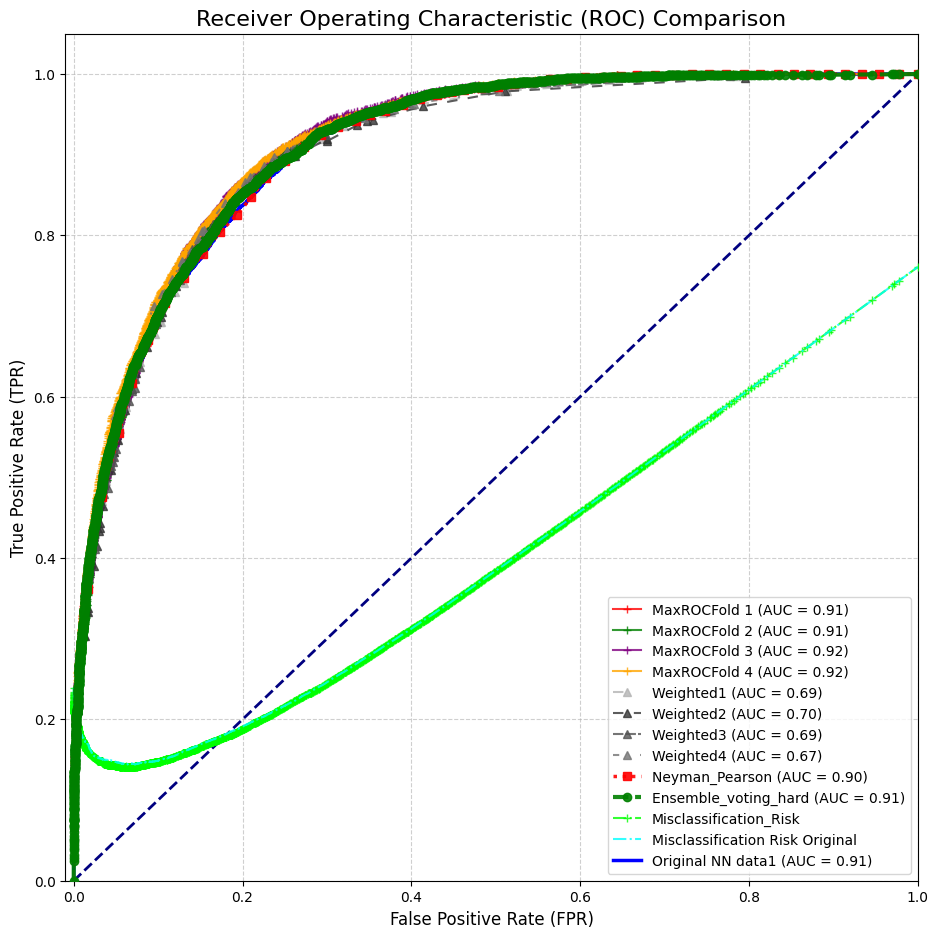

In [41]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)

# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="logistic_weighted_adult", prior_prob=prior_proba
)

## Bootstrap method

In [19]:
from sklearn.utils import resample

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds 
list_folds_best_models = []  # List to store best models from all folds

list_weighted_clfs = []

# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.01)
majority_class_weight = 1.0 - minority_class_weight

n_iterations = 4
n_size = int(len(train_data[:, -1]) * 0.75)

original_indices = np.arange(len(train_data[:, -1]))

for ii in range(n_iterations):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage

    print(f"--- Starting Iteration {ii + 1}/{n_iterations} ---")
    train_indices = resample(original_indices, replace=True, n_samples=n_size, random_state=ii)
    test_indices = np.setdiff1d(original_indices, train_indices, assume_unique=False)

    X_train_fold = train_data[train_indices][:, :-1]
    y_train_fold = train_data[train_indices][:, -1]
    X_test_fold = train_data[test_indices][:, :-1]
    y_test_fold = train_data[test_indices][:, -1]
    
    for w in minority_class_weight:
        class_weights = {0: 1 - w, 1: w}

        clf_weighted = LogisticRegression(fit_intercept=True, class_weight=class_weights)
        clf_weighted.fit(X_train_fold, y_train_fold)

        res = get_fpr_tpr(clf_weighted, X_test_fold, y_test_fold, threshold=0.5)

        array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test_fold, clf_weighted.predict_proba(X_test_fold)[:, 1])

        current_result = {
            "model": clf_weighted,
            "fpr": res["fpr"],
            "tpr": res["tpr"],
            "threshold": 0.5,
            "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
        }
        list_weighted_clfs.append(current_result)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs.copy())
    list_folds_best_models.append(best_clfs.copy())

--- Starting Iteration 1/4 ---
--- Starting Iteration 2/4 ---
--- Starting Iteration 3/4 ---
--- Starting Iteration 4/4 ---


In [20]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/Logistic_adult_weighted_bootstrap.pkl')





Data saved to pickle/Logistic_adult_weighted_bootstrap.pkl


{'best_models': [[{'model': LogisticRegression(class_weight={0: np.float64(0.989), 1: np.float64(0.011)}),
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.0817824377457405),
    'threshold': np.float64(0.1722862732388809)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.979),
                                     1: np.float64(0.020999999999999998)}),
    'fpr': np.float64(8.08996035919424e-05),
    'tpr': np.float64(0.08676277850589777),
    'threshold': np.float64(0.306606752878159)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.979),
                                     1: np.float64(0.020999999999999998)}),
    'fpr': np.float64(0.0001617992071838848),
    'tpr': np.float64(0.09017038007863695),
    'threshold': np.float64(0.2948101494839025)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.9390000000000001),
                                     1: np.float64(0.06099999999999999)}),
    'fpr': np.float64(0.00024269881077582719),
   

In [21]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/Logistic_adult_weighted_bootstrap.pkl')

Data loaded successfully.


In [22]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 6823 models across all folds.
Extracting full dataset...
Getting predictions from all models...



--- Plotting all ROC curves for comparison ---


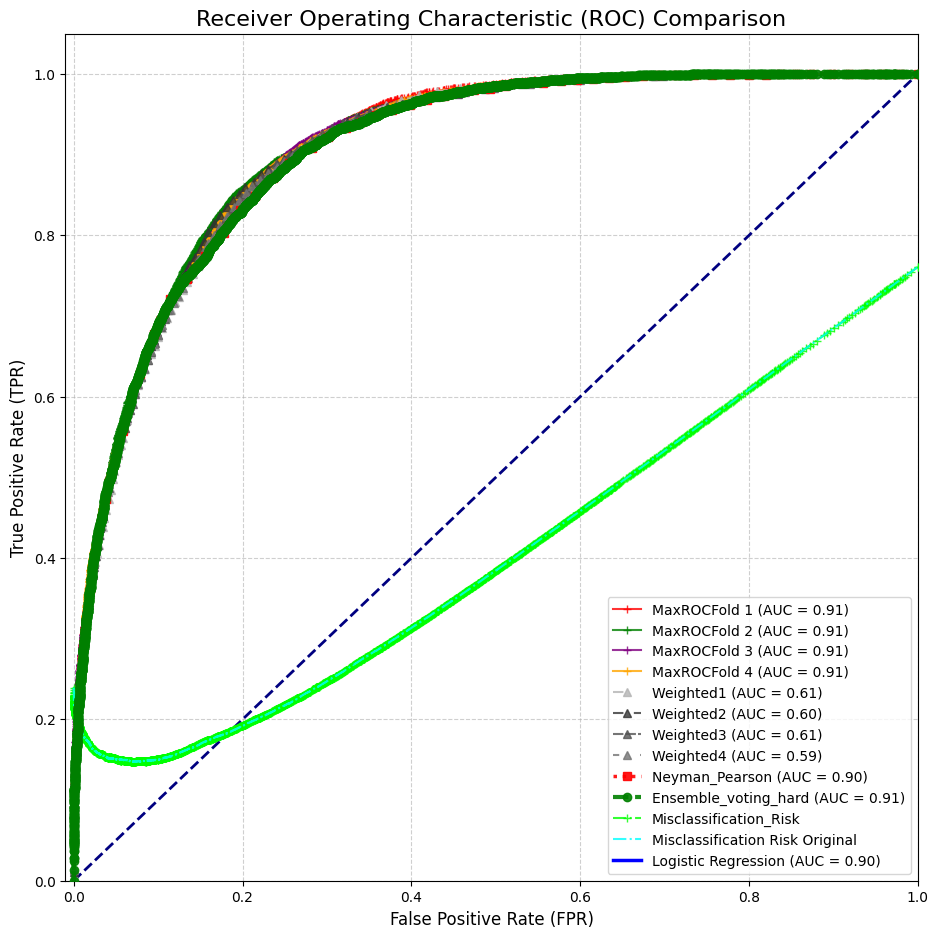

In [ ]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="logistic_weighted_adult_bootstrap", prior_prob=prior_proba
)

### NOTES
* CV - Traiining data is large, stable, overlapping data partitions. Stable performance, good for estimating model accuracy.
* Bootstrap - More random samples with replacement. Diverse models, good for building an ensemble that generalizes well.